# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1)
RANDOM_STATE = 12345

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Много разных категориальных и количествнных признаков. Некоторые из них никак не влияют на цену автомобиля: например, DateCrawled - Дата скачивания анкеты из базы, RegistrationMonth - месяц регистрации автомобиля, DateCreated - дата создания анкеты, NumberOfPictures - количество фотографий автомобиля, PostalCode - почтовый индекс владельца анкеты, LastSeen - дата последней активности пользователя. Поэтому просто удалим эти столбцы. Но сначала проверим на наличие дубликатов.

Большое количество пропущенных значений. В категориальных данных заменим пропущенные значения на Nan.

In [3]:
df.duplicated().sum()

4

Удалим дубли.

In [4]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [5]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Посмотрим какой процент от данных составляют пропущенные значения.

In [6]:
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

NotRepaired         20.079297
VehicleType         10.579487
FuelType            9.282802 
Gearbox             5.596772 
Model               5.560651 
Brand               0.000000 
Kilometer           0.000000 
Power               0.000000 
RegistrationYear    0.000000 
Price               0.000000 
dtype: float64

В количественных данных отсутствуют пропущенные значения, но там есть нули. А в категориальных процент пропущенных данных составляет от 5% до 20%. Как я писал выше, заменим пропущенные значения на Nan, то есть нет данных. Nan будет новой категорией.

In [7]:
category_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
df[category_col] = df[category_col].fillna('Nan')
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,Nan,1993,manual,0,golf,150000,petrol,volkswagen,Nan
1,18300,coupe,2011,manual,190,Nan,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,Nan
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,Nan,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,Nan,2005,Nan,0,Nan,20000,Nan,sonstige_autos,Nan
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Рассмотрим распределение количественных признаков.

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Стоит избавиться от аномально низких и высоких значений количественных признаков. Рассмотрим их поподробнее.

In [9]:
# напишем функцию для визуализации количественных признаков
def visual_column(df, column, bins):
    plt.figure(figsize=(14, 6))
    plt.title('График распределения колонки ' + column, fontsize=16)
    plt.ylabel('Count')
    sns.distplot(df[column], kde=False, bins=bins)
    plt.show()
    plt.figure(figsize=(14, 6))
    plt.ylabel(column)
    sns.boxplot(data=df[column], palette='rainbow')
    plt.show()

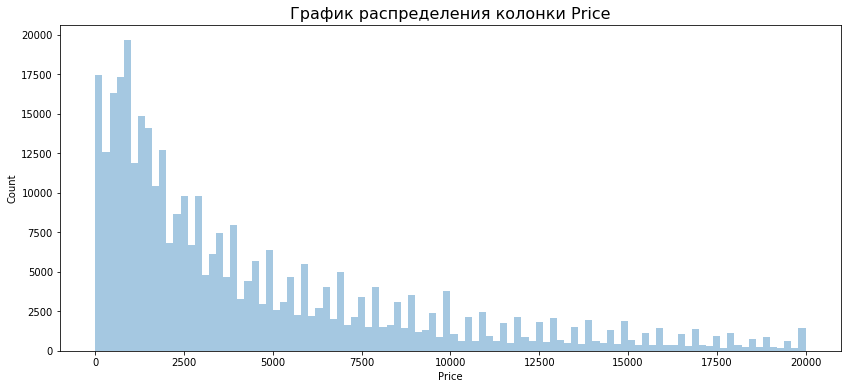

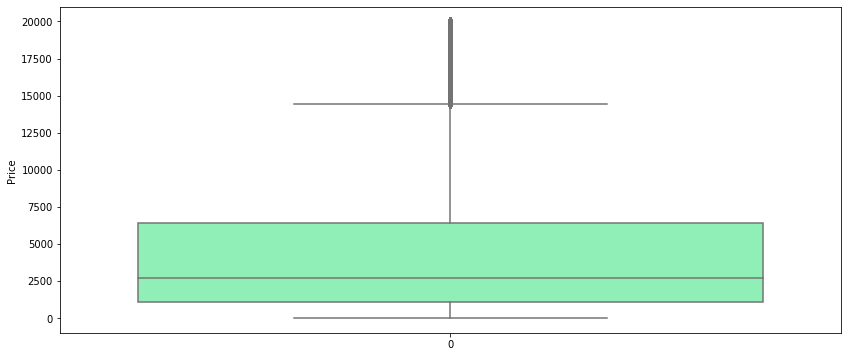

In [10]:
visual_column(df, 'Price', 100)

Так как на современных сайтах домена ру нет машин с ценой равной 0, то удалим только нулевые значения. Остальные значения оставим как есть, чтобы не удалять лишние данные, тем более это целевой признак.

In [11]:
df_good = df[df['Price'] > 0].reset_index(drop=True)
df_good

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,Nan,1993,manual,0,golf,150000,petrol,volkswagen,Nan
1,18300,coupe,2011,manual,190,Nan,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,Nan
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
343588,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
343589,2200,Nan,2005,Nan,0,Nan,20000,Nan,sonstige_autos,Nan
343590,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
343591,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Далее рассмотрим колонку RegistrationYear.

In [12]:
df_good['RegistrationYear'].value_counts(bins=15)

(1599.933, 2199.867]    343463
(991.0, 1599.933]       45    
(9399.067, 9999.0]      19    
(4599.6, 5199.533]      17    
(2799.8, 3399.733]      9     
(5799.467, 6399.4]      8     
(3999.667, 4599.6]      6     
(2199.867, 2799.8]      6     
(6999.333, 7599.267]    5     
(5199.533, 5799.467]    4     
(8799.133, 9399.067]    3     
(7599.267, 8199.2]      3     
(8199.2, 8799.133]      2     
(3399.733, 3999.667]    2     
(6399.4, 6999.333]      1     
Name: RegistrationYear, dtype: int64

БОльшая часть данных находится в диапазоне [1599.933, 2199.867], логично будет сузить его с 1900 года до 2020 года.

In [13]:
df_good = df_good.query('RegistrationYear > 1900 and RegistrationYear < 2021').copy()
print('Минимальный год регистрации:', df_good['RegistrationYear'].min())
print('Максимальный год регистрации:', df_good['RegistrationYear'].max())

Минимальный год регистрации: 1910
Максимальный год регистрации: 2019


Рассмотрим колонку Power.

In [14]:
df_good['Power'].value_counts(bins=15)

(-20.001, 1333.333]       343237
(1333.333, 2666.667]      126   
(5333.333, 6666.667]      16    
(8000.0, 9333.333]        10    
(10666.667, 12000.0]      9     
(6666.667, 8000.0]        9     
(2666.667, 4000.0]        9     
(12000.0, 13333.333]      7     
(9333.333, 10666.667]     7     
(16000.0, 17333.333]      6     
(18666.667, 20000.0]      4     
(14666.667, 16000.0]      4     
(4000.0, 5333.333]        4     
(17333.333, 18666.667]    3     
(13333.333, 14666.667]    3     
Name: Power, dtype: int64

In [15]:
df_good.query('Power == 0')['Power'].count()

36259

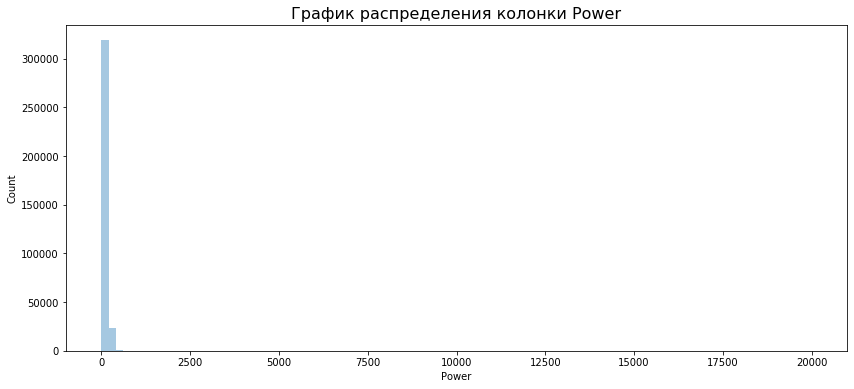

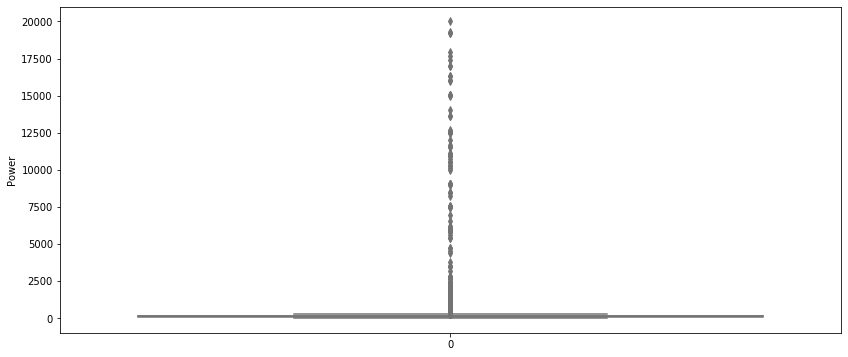

In [16]:
visual_column(df_good, 'Power', 100)

Очень много нулей а так же аномально высоких значений в колонке Power. Нули заменим медианой в зависимости от других значений. А так же удалим значения, которые превышают 700 л.с., чтобы не исключать дорогие машины.

In [17]:
df_good['Power'] = df_good['Power'].replace(0, np.nan)
median_power = df_good.groupby(['Brand', 'Model', 'FuelType', 'Kilometer'])['Power'].transform('median')
df_good['Power'] = df_good['Power'].fillna(median_power)
print('К-во пропусков:', df_good['Power'].isnull().sum())

К-во пропусков: 846


Удалим незаполненные значения и значения больше 700 л.с.

In [18]:
df_good.dropna(inplace=True)
df_good.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

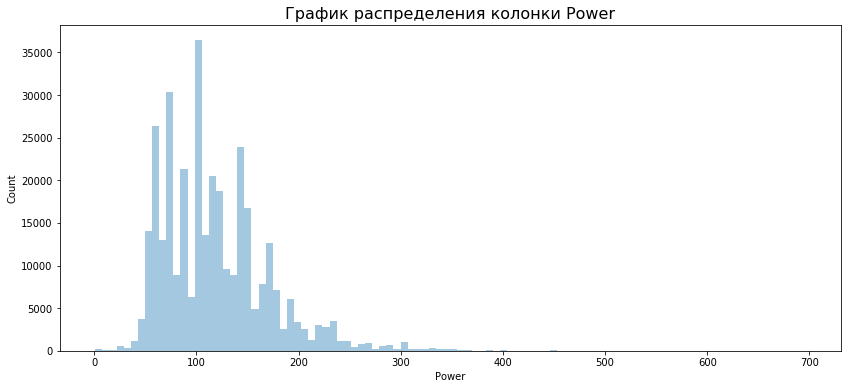

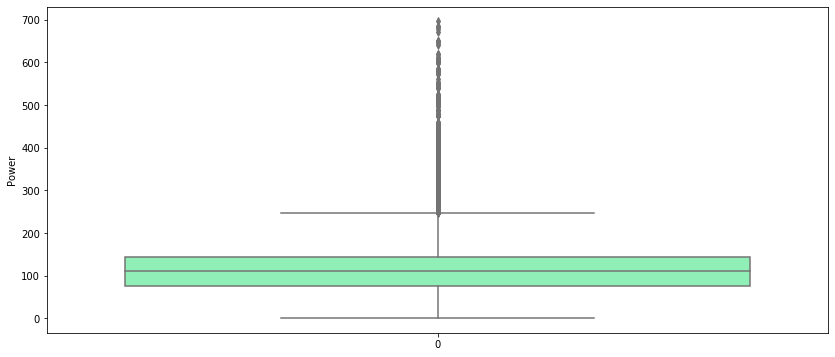

In [19]:
df_good = df_good.query('Power < 700').copy()
visual_column(df_good, 'Power', 100)

Рассмотрим колонку Kilometer.

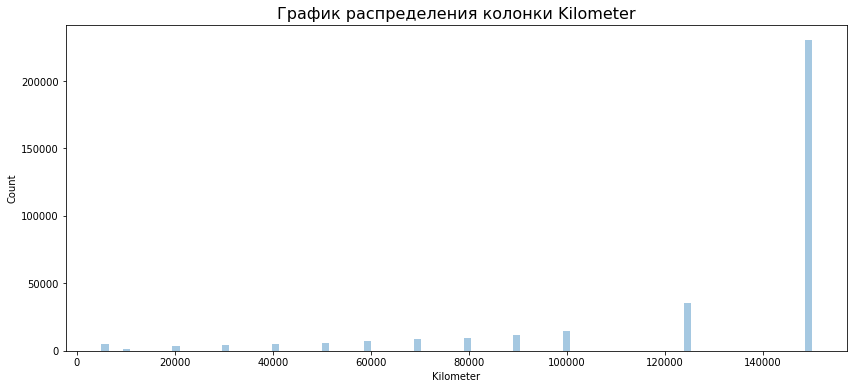

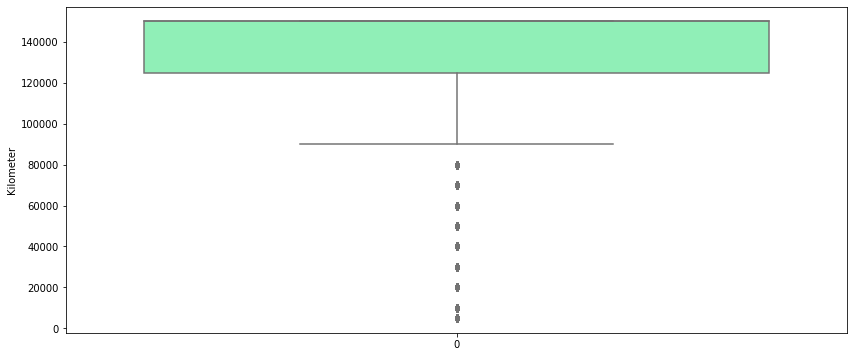

In [20]:
visual_column(df_good, 'Kilometer', 100)

В данных есть как новые так и старые автомобили, так что лучше оставим данные как есть.

Мы проанализировали данные, удалили дубликаты, аномальные значения и в категориальных данных ввели новую категорию Nan, чтобы сохранить большую часть данных. Можно приступать к обучению модели.

## Обучение моделей

Для обучения LGBMRegressor'а преобразуем тип категориальных данных.

In [21]:
df_good_cat_col = ['NotRepaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model', 'Brand']
df_good[df_good_cat_col] = df_good[df_good_cat_col].astype('category')

In [22]:
df_good.dtypes

Price               int64   
VehicleType         category
RegistrationYear    int64   
Gearbox             category
Power               float64 
Model               category
Kilometer           int64   
FuelType            category
Brand               category
NotRepaired         category
dtype: object

Преобразуем категориальные признаки в численные с помощью get_dummies(). используем drop_first, чтобы не попасть в дамми-ловушку.

In [23]:
df_good_ohe = pd.get_dummies(df_good, drop_first=True).copy()
df_good_ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
0,480,1993,90.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,18300,2011,190.0,125000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75.0,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3600,2008,69.0,90000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


Разобьем данные на выборки: обучающую, валидационную и тестову в соотношении 3:1:1.

In [24]:
features = df_good_ohe.drop('Price', axis=1).copy()
target = df_good_ohe['Price'].copy()
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              train_size=0.60, 
                                                                              test_size=0.40, 
                                                                              random_state=RANDOM_STATE)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            train_size=0.50, 
                                                                            test_size=0.50, 
                                                                            random_state=RANDOM_STATE)

In [25]:
print('Размер выборки features_train:', features_train.shape)
print('Размер выборки target_train:', target_train.shape)
print('Размер выборки features_valid:', features_valid.shape)
print('Размер выборки target_valid:', target_valid.shape)
print('Размер выборки features_test:', features_test.shape)
print('Размер выборки target_test:', target_test.shape)

Размер выборки features_train: (205368, 310)
Размер выборки target_train: (205368,)
Размер выборки features_valid: (68456, 310)
Размер выборки target_valid: (68456,)
Размер выборки features_test: (68456, 310)
Размер выборки target_test: (68456,)


Разбили данные успешно.

Масштабируем признаки с помощью StandardScaler().

In [26]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [27]:
features_train[numeric] = scaler.transform(features_train[numeric]).copy()
features_valid[numeric] = scaler.transform(features_valid[numeric]).copy()
features_test[numeric] = scaler.transform(features_test[numeric]).copy()

In [28]:
features_train.head()

,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
308835,-0.711336,0.532111,0.576776,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
136872,1.741520,-1.105491,0.576776,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
97758,-1.120146,-0.823145,0.576776,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
165041,0.106282,0.023890,0.576776,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49833,-0.438797,-0.333747,0.576776,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


Данные отмасштабированы.

### Линейная регрессия

Начнем с линейной регрессии.

In [29]:
model_lr = LinearRegression()

In [30]:
start = time.time() 
model_lr.fit(features_train, target_train)
end_time_fit = time.time() - start
print('End time fit: ', end_time_fit)

End time fit:  25.57855248451233


In [31]:
start = time.time() 
predictions_lr = model_lr.predict(features_valid)
end_time_predict = time.time() - start
print('End time predict: ', end_time_predict)

End time predict:  0.19343280792236328


In [32]:
results = []
results.append({'Модель': 'LinearRegression', 
                'Параметры': np.nan, 
                'Время обучения': end_time_fit, 
                'Время предсказания': end_time_predict, 
                'RMSE': sqrt(mean_squared_error(target_valid, predictions_lr))})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,Время предсказания,RMSE
0,LinearRegression,NaN,25.578552,0.193433,2656.608242


Очень большая RMSE, но время обучения и предсказания небольшие. Рассмотрим модели дальше и сравним.

### Случайный лес

In [33]:
model_rf = RandomForestRegressor()

In [34]:
start = time.time() 
model_rf.fit(features_train, target_train)
end_time_fit = time.time() - start
print('End time fit: ', end_time_fit)

End time fit:  59.119484186172485


In [35]:
start = time.time() 
predictions_rf = model_rf.predict(features_valid)
end_time_predict = time.time() - start
print('End time predict:', end_time_predict)

End time predict: 0.6453680992126465


In [36]:
results.append({'Модель': 'RandomForestRegressor', 
                'Параметры': np.nan, 
                'Время обучения': end_time_fit, 
                'Время предсказания': end_time_predict, 
                'RMSE': sqrt(mean_squared_error(target_valid, predictions_rf))})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,Время предсказания,RMSE
0,LinearRegression,NaN,25.578552,0.193433,2656.608242
1,RandomForestRegressor,NaN,59.119484,0.645368,1702.510632


In [37]:
#for depth in range(1,16):
#    
#    for estimator in range(10, 121, 10):
#        
#        model_rf = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
#        start = time.time() 
#        model_rf.fit(features_train, target_train)
#        end_time_fit = time.time() - start
#        start = time.time() 
#        predictions_rf = model_rf.predict(features_valid)
#        end_time_predict = time.time() - start
#        results.append({'Модель': 'RandomForestRegressor', 
#                'Параметры': estimator, 
#                'Время обучения': end_time_fit, 
#                'Время предсказания': end_time_predict, 
#                'RMSE': sqrt(mean_squared_error(target_valid, predictions_rf))})
#
#pd.DataFrame(results)

В результате обучения модели случайного леса с различными параметрами (закоменченый код выше) было выявлено, что лучший результат RMSE составляет 1912,6 при количестве деревьев 90, глубине 11. При этом время предсказания составила 0,739, а время обучения - 268,68 секунд. Не будем добавлять эти данные в нашу результирующую таблицу, так как модель случайного леса без параметров показала лучший результат за более короткое время.

### LGBMRegressor

In [38]:
params = {'boosting_type': 'gbdt', 
          'max_depth': 11, 
          'n_estimators': 210}
model_lgbm = LGBMRegressor(**params)

In [39]:
start = time.time() 
model_lgbm.fit(features_train, target_train)
end_time_fit = time.time() - start
print('End time fit: ', end_time_fit)

End time fit:  18.229863166809082


In [40]:
start = time.time() 
predictions_lgbm = model_lgbm.predict(features_valid)
end_time_predict = time.time() - start
print('End time predict: ', end_time_predict)

End time predict:  2.098247766494751


In [41]:
results.append({'Модель': 'LGBMRegressor', 
                'Параметры': params, 
                'Время обучения': end_time_fit, 
                'Время предсказания': end_time_predict, 
                'RMSE': sqrt(mean_squared_error(target_valid, predictions_lgbm))})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,Время предсказания,RMSE
0,LinearRegression,NaN,25.578552,0.193433,2656.608242
1,RandomForestRegressor,NaN,59.119484,0.645368,1702.510632
2,LGBMRegressor,"{'boosting_type': 'gbdt', 'max_depth': 11, 'n_estimators': 210}",18.229863,2.098248,1696.452824


LGBMRegressor улучшил показатель RMSE, но время обучения и время предсказания значительно выше.

### CatBoostRegressor

In [42]:
features = df_good.drop('Price', axis=1).copy()
target = df_good['Price'].copy()
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              train_size=0.60, 
                                                                              test_size=0.40, 
                                                                              random_state=RANDOM_STATE)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            train_size=0.50, 
                                                                            test_size=0.50, 
                                                                            random_state=RANDOM_STATE)

model_cbr = CatBoostRegressor(iterations=240, loss_function='RMSE', depth=13, cat_features=df_good_cat_col)
    
start = time.time() 
model_cbr.fit(features_train, target_train)
end_time_fit = time.time() - start

start = time.time() 
predictions_cbr = model_cbr.predict(features_valid, verbose=1)
end_time_predict = time.time() - start

results.append({'Модель': 'CatBoostRegressor', 
                        'Параметры': {'iterations': '240', 
                                      'loss_function': 'RMSE', 
                                      'depth': '13'}, 
                        'Время обучения': end_time_fit, 
                        'Время предсказания': end_time_predict, 
                        'RMSE': sqrt(mean_squared_error(target_valid, predictions_cbr))})

0:	learn: 4425.9993480	total: 2.74s	remaining: 10m 55s
1:	learn: 4327.9264018	total: 5.14s	remaining: 10m 11s
2:	learn: 4234.3500179	total: 7.44s	remaining: 9m 47s
3:	learn: 4143.4034493	total: 9.65s	remaining: 9m 29s
4:	learn: 4055.3575748	total: 12.1s	remaining: 9m 30s
5:	learn: 3970.1419889	total: 14.4s	remaining: 9m 22s
6:	learn: 3888.7559973	total: 16.6s	remaining: 9m 13s
7:	learn: 3809.5094269	total: 18.9s	remaining: 9m 8s
8:	learn: 3734.3888887	total: 21s	remaining: 9m
9:	learn: 3662.4220084	total: 23.3s	remaining: 8m 56s
10:	learn: 3592.3097990	total: 25.5s	remaining: 8m 51s
11:	learn: 3524.1456035	total: 27.8s	remaining: 8m 48s
12:	learn: 3458.6011566	total: 30.2s	remaining: 8m 47s
13:	learn: 3394.3032717	total: 32.6s	remaining: 8m 46s
14:	learn: 3331.7980722	total: 34.7s	remaining: 8m 40s
15:	learn: 3272.7919409	total: 36.9s	remaining: 8m 36s
16:	learn: 3215.1262888	total: 39.2s	remaining: 8m 34s
17:	learn: 3160.1668840	total: 41.4s	remaining: 8m 30s
18:	learn: 3107.5040766	t

In [43]:
pd.DataFrame(results)

,Модель,Параметры,Время обучения,Время предсказания,RMSE
0,LinearRegression,NaN,25.578552,0.193433,2656.608242
1,RandomForestRegressor,NaN,59.119484,0.645368,1702.510632
2,LGBMRegressor,"{'boosting_type': 'gbdt', 'max_depth': 11, 'n_estimators': 210}",18.229863,2.098248,1696.452824
3,CatBoostRegressor,"{'iterations': '240', 'loss_function': 'RMSE', 'depth': '13'}",594.069760,0.532727,1678.712935


CatBoostRegressor имеет лучший показатель RMSE, время предсказания меньше чем у случайного леса и LGBMRegressor'а, но время на обучение во много раз превышает RandomForestRegressor и LGBMRegressor.

## Анализ моделей

Лучшей по показателю RMSE и времени обучения стала модель LGBMRegressor'а, но время предсказания у неё очень высокое. При выборе оптимальной модели нужно отталкиваться от цели и задачи. Если нужна скорость обучения и предсказания выше, а RMSE не так важна, то лучше взять линейную регрессию. CatBoostRegressor на большом количестве данных будет очень долго обучаться, но время предсказания у него одно из лучших. Но если смотреть в совокупности на все параметры, то лучше использовать LGBMRegressor: при лучшей RMSE, самая высокая скорость обучения и небольшое время на предсказание.

In [44]:
model = LGBMRegressor(boosting_type='gbdt', max_depth = 11, n_estimators = 210)

In [45]:
start = time.time() 
model.fit(features_train, target_train)
end_time_fit = time.time() - start
print('End time fit: ', end_time_fit)

End time fit:  32.26772999763489


In [46]:
start = time.time() 
predictions = model.predict(features_test)
end_time_predict = time.time() - start
print('End time predict: ', end_time_predict)

End time predict:  2.2001397609710693


In [47]:
print(sqrt(mean_squared_error(target_test, predictions)))

1646.6200949964189


На тестовых данных модель показала себя еще лучше.

Сравним работу нашей итоговой модели с работой случайной модели.

In [48]:
dummy = DummyRegressor(strategy='mean')

dummy.fit(features_train, target_train)

predictions_dummy = dummy.predict(features_test)
print('RMSE dummy:', sqrt(mean_squared_error(target_test, predictions_dummy)))

RMSE dummy: 4501.135271329311


In [49]:
dummy = DummyRegressor(strategy='median')

dummy.fit(features_train, target_train)

predictions_dummy = dummy.predict(features_test)
print('RMSE dummy:', sqrt(mean_squared_error(target_test, predictions_dummy)))

RMSE dummy: 4790.837990596376


Наша модель по качеству предсказаний оказалась гораздо лучше.

## Вывод

Итак, в процессе построения модели для предсказания цены на автомобили мы преобразовали данные, удалив выбросы, частично заполнив пустые значения и удалили дубликаты в данных, а так же удалили столбцы с данными, которые никак не влияют на цену автомобиля. В качестве моделей были использованы линейная регрессия, случайный лес, LGBMRegressor и CatBoostRegressor. После обучения моделей сверили основные параметры, которые важны заказчику: это время на обучение/предсказание и качество предсказания. В результате для финальной модели была выбрана модель LGBMRegressor'а, которая в совокупности показала наилучшие характеристики на валидационных данных: самое низкое время обучения, RMSE немного больше, чем у CatBoostRegressor'а, лишь время предсказания выше в 3-4 раза.